In [1]:
import torch
import math
from matplotlib import pyplot as plt

df = 300
propogation_dists = [df, df]
wl = 532e-6
pixel_size = 18e-3
k = torch.pi * 2 / wl

LOAD DATASET

Label: 8


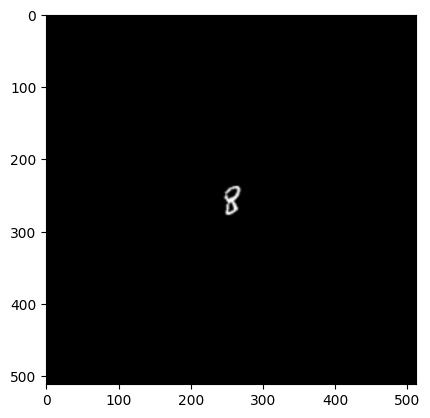

In [2]:
# from core.config import torch_floating_point_type, torch_complex_float_type
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(56, 56), antialias=False),
    v2.ToDtype(torch_floating_point_type, scale=True),
    # v2.RandomInvert(p=1.0),
    v2.Pad(padding_mode='constant',fill=0, padding=228),
    # v2.GaussianNoise(mean=0.1,sigma=0.2),
    v2.ToDtype(torch_complex_float_type, scale=True),
    v2.Lambda(lambda x: x/torch.sqrt((abs(x)**2).sum())),
])
train_dataset: Dataset = MNIST(root ='../../data/datasets/', download = True, train=True, transform=transforms)
test_dataset: Dataset = MNIST(root ='../../data/datasets/', download = True, train=False, transform=transforms)

sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
image, label = train_dataset[sample_idx]
plt.imshow(abs(image[0]), cmap = 'gray')
print('Label:', label)

In [3]:
# from services.geometry import meshgrid

img_shape = train_dataset[0][0][0].shape
n_x = img_shape[0]
app_size = n_x * pixel_size

x,y = meshgrid(size_x=app_size, n_x=n_x)

GENERATE REQUIRED REGIONS (MASKS)

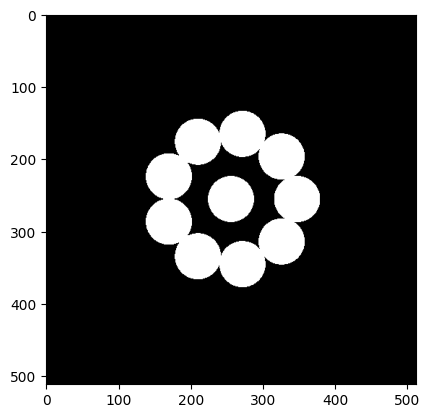

In [4]:
num_rings = 1
area_r = app_size /16

num_classes = len(train_dataset.classes)
num_phi = math.ceil((num_classes - 1) / num_rings) # one class in center
dphi = 2 * math.pi / num_phi
dr = 2 * num_phi * area_r / math.pi

req_center_x = [0.]
req_center_y = [0.]

cur_r = dr/2
cur_start_phi = 0
for _ in range(num_rings):
    cur_phi = cur_start_phi
    while len(req_center_x) < num_classes and cur_phi < cur_start_phi + 2 * math.pi:
        req_center_x.append(cur_r * math.cos(cur_phi))
        req_center_y.append(cur_r * math.sin(cur_phi))
        cur_phi += dphi

    cur_r += dr
    cur_start_phi += dphi / 2

# find correspond inds
cell_dist = x[0,1] - x[0,0]

req_center_x = x.new_tensor(req_center_x)
req_center_y = x.new_tensor(req_center_y)
req_center_x_ind = torch.ceil((req_center_x - x.min())/cell_dist)
req_center_y_ind = torch.ceil((req_center_y - y.min())/cell_dist)

req_masks = x.new_zeros((num_classes, n_x, n_x))
for i in range(num_classes):
    req_masks[i] = (x - req_center_x[i]) ** 2 + (y - req_center_y[i]) ** 2 <= area_r ** 2

plt.imshow(req_masks.sum(dim=0).cpu().numpy() > 0, cmap = 'gray')

DEFINE SPLINEs (LAYERS)

In [5]:
degree = 3

n_points = n_x
nknots = [20, 80, 160, 320]

c_s = []
knots_x_s = []
knots_y_s = []

n_layeres_max = len(nknots)
for i in range(n_layeres_max):
    knots_x_s.append(torch.linspace(-app_size / 2, app_size / 2, nknots[i]).to(device=x.device, dtype=x.dtype))
    knots_y_s.append(torch.linspace(-app_size / 2, app_size / 2, nknots[i]).to(device=x.device, dtype=x.dtype))
    n_c = (nknots[i] + degree - 1) ** 2
    # c_s.append(math.pi * 2 * torch.rand(n_c).to(device=x.device, dtype=x.dtype))
    c_s.append(x.new_zeros(n_c))

Pre-train first lvl to focus on outer surface

  0%|          | 0/2000 [00:00<?, ?it/s]

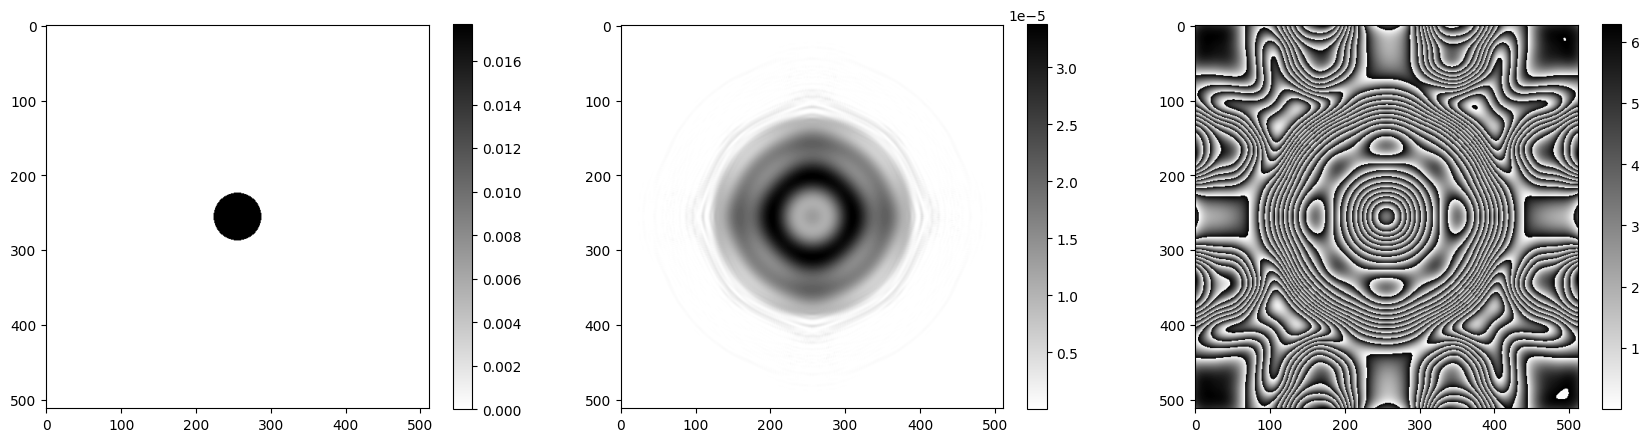

(<Figure size 2100x500 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object),
  <matplotlib.image.AxesImage at 0x260919bb190>])

In [6]:
from .flux_visualizer import show_planar_flux
from .sinc_propagator import propagation_sinc_prepare, propagation_sinc
# from loss_funcs import rrmse
from .models import LayeredDOE
from torch.optim.lr_scheduler import ExponentialLR
from tqdm.notebook import tqdm

input = x**2 + y**2 <= area_r **2
input = (input/torch.sqrt((abs(input)**2).sum()))
input = input.to(dtype=torch_complex_float_type)

focur_area_r = dr + area_r
req_distr = x**2 + y**2 <= focur_area_r **2
req_distr = req_distr / req_distr.sum()

loss_fn = rrmse
lr_start = 1e-1
num_iters = int(2e3)

c_s[0].requires_grad = True
doe = LayeredDOE(x=x, y=y, degree = degree, c_s=c_s[:1], knots_x_s=knots_x_s[:1], knots_y_s=knots_y_s[:1])
optimizer = torch.optim.Adam(doe.parameters(), lr=lr_start, betas=(0.9, 0.99999), eps=1e-08, weight_decay=0)
lr_end = lr_start/100
gamma = math.pow(lr_end / lr_start, 1 / num_iters)
scheduler = ExponentialLR(optimizer, gamma=gamma)


prop_params = [propagation_sinc_prepare(field_shape=img_shape,
                                   wavenumber=k,
                                   side_length=app_size,
                                   propagation_dist=f) for f in propogation_dists]

with tqdm(total=num_iters) as pbar:
    for i in range(num_iters):
        optimizer.zero_grad()

        result = propagation_sinc(u1=input, propagator_params=prop_params[0])
        result = doe(result)
        result = propagation_sinc(u1=result, propagator_params=prop_params[1])
        result = abs(result) ** 2

        loss = loss_fn(result, req_distr)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if i % 5 == 4:
            pbar.set_description(f'Iteration {i + 1:5d}.  Loss: {loss:.3f}')
        pbar.update(1)

c_s[0].requires_grad = False

show_planar_flux(image=[abs(input),  result, doe.get_phase_surface()])

Save/Load prepared data

In [10]:
# # SAVE RESULTS TO FILE
# f_name = 'tmp_data.pt'
# d = {'c_s': c_s,
#      'knots_x_s': knots_x_s,
#      'knots_y_s': knots_y_s,
#      'degree': degree,
#      'nknots': nknots,}
#
# torch.save(d, f_name)

In [11]:
# LOAD RESULTS FROM FILE
f_name = 'tmp_data.pt'
d = torch.load(f_name)

nknots = d['nknots']
c_s = d['c_s']
knots_x_s = d['knots_x_s']
knots_y_s = d['knots_y_s']
degree = d['degree']

C:\Users\Egor\AppData\Local\Temp\ipykernel_4912\4285297936.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(f_name)


SUPPORT FUNCTIONS

In [12]:
from .models import LayeredDOE

def get_layered_doe(num_layeres):
    return LayeredDOE(x=x, y=y, degree = degree, c_s=c_s[:num_layeres], knots_x_s=knots_x_s[:num_layeres], knots_y_s=knots_y_s[:num_layeres])

def get_data_loaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

DNN TRAINING

Start training.


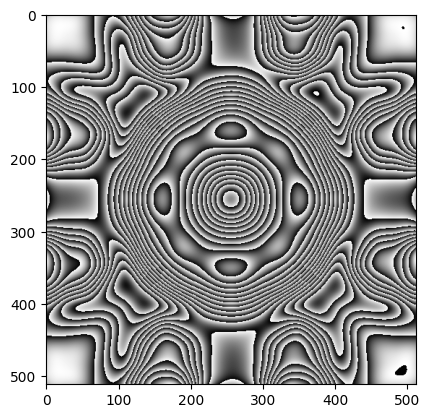

New stage begin.Batch size: 32; 2 spline layers; 0.01 starting step; 20 epochs.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

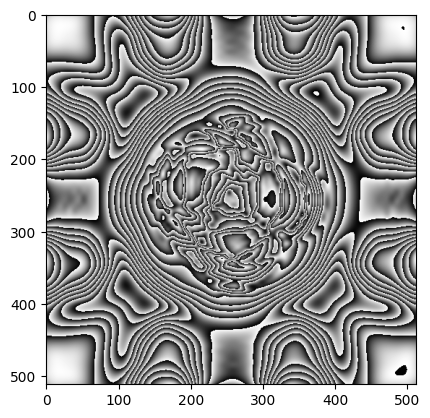

New stage begin.Batch size: 64; 3 spline layers; 0.01 starting step; 20 epochs.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

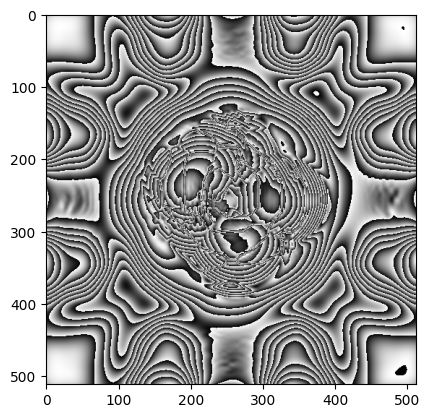

New stage begin.Batch size: 128; 4 spline layers; 0.001 starting step; 20 epochs.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Finished Training. 3.598e+04 s.


In [13]:
from tqdm.notebook import tqdm
import math
from .models import SimpleLayeredDNN
from torch.nn import CrossEntropyLoss
import time
from torch.optim.lr_scheduler import ExponentialLR

criterion = CrossEntropyLoss()

stages = [ # (num_layers, batch_size, lr_start, num_epochs)
        # (1,16,1e-1,1),
        (2,32,1e-2,20),
        (3,64,1e-2,20),
        (4,128,1e-3,20),
        ]

num_iters_to_log = 5

for c in c_s:
    c.requires_grad = True

print(f'Start training.')
start_time = time.time()
for (num_layers, batch_size, lr_start, num_epochs) in stages:
    train_loader,_ = get_data_loaders(batch_size)
    num_iters_in_epoch = len(train_loader)

    layered_dnn = SimpleLayeredDNN(n_side_points=n_x,
                                       app_size=app_size,
                                       wave_number=k,
                                       propagation_dists=propogation_dists,
                                       target_regions=req_masks,
                                       layered_doe=get_layered_doe(num_layers))
    layered_dnn.to(device=device)
    plt.imshow(layered_dnn.doe.get_phase_surface().cpu().detach().numpy(), cmap = 'gray')
    plt.show()

    optimizer = torch.optim.Adam(layered_dnn.parameters(), lr=lr_start, betas=(0.9, 0.99999), eps=1e-08, weight_decay=0)

    lr_end = lr_start/10
    gamma = math.pow(lr_end / lr_start, 1 / num_epochs)
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    print(f'New stage begin.Batch size: {batch_size}; {num_layers} spline layers; {lr_start} starting step; {num_epochs} epochs.')

    with tqdm(total=num_epochs) as sbar:
        sbar.set_description(f'Stage: {num_layers} layers, batch size={batch_size}, start LR= {lr_start}.')
        for epoch in range(num_epochs):
            running_loss = 0.0
            with tqdm(total=num_iters_in_epoch) as pbar:
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data[0].to(device=device), data[1].to(device=device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = layered_dnn(inputs)

                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    # print statistics
                    running_loss += loss.item()
                    if i % num_iters_to_log == num_iters_to_log-1:    # print every 100 mini-batches
                        # num_iters = i * batch_size + inputs.size(dim=0)
                        pbar.set_description(f'Epoch #{epoch + 1}, iteration {i + 1:5d}.  Loss: {running_loss / i+1:.3f}')
                    pbar.update(1)
            scheduler.step()
            sbar.update(1)

print(f'Finished Training. {(time.time() - start_time):.4} s.')
for c in c_s:
    c.requires_grad = False

Accuracy for class: 0 - zero is 98.5 %
Accuracy for class: 1 - one is 99.4 %
Accuracy for class: 2 - two is 0.0 %
Accuracy for class: 3 - three is 30.3 %
Accuracy for class: 4 - four is 0.0 %
Accuracy for class: 5 - five is 0.0 %
Accuracy for class: 6 - six is 0.0 %
Accuracy for class: 7 - seven is 0.0 %
Accuracy for class: 8 - eight is 0.0 %
Accuracy for class: 9 - nine is 0.0 %


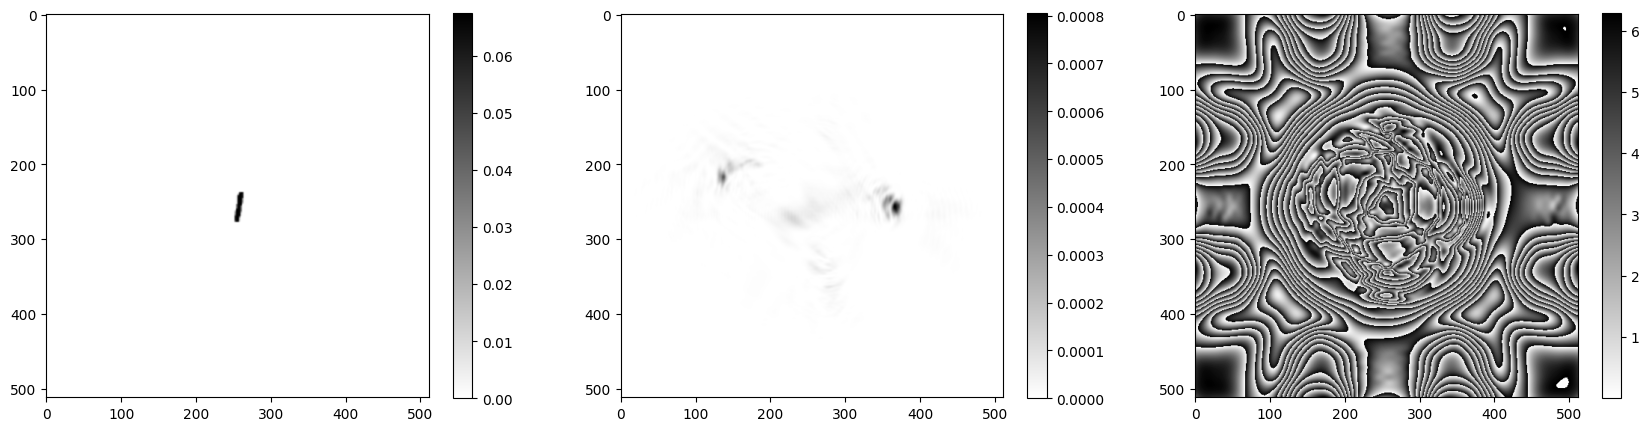

(<Figure size 2100x500 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object),
  <matplotlib.image.AxesImage at 0x261fc05af50>])

In [15]:
from .models import SimpleLayeredDNN
# prepare to count predictions for each class
classes = train_dataset.classes
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

layered_dnn = SimpleLayeredDNN(n_side_points=n_x,
                                   app_size=app_size,
                                   wave_number=k,
                                   propagation_dists=propogation_dists,
                                   target_regions=req_masks,
                                   layered_doe=get_layered_doe(2))
layered_dnn.to(device=x.device)

_,test_loader = get_data_loaders(128)

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device=x.device), data[1].to(device=x.device)
        outputs = layered_dnn(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

show_planar_flux(image=[abs(images[0,0]),  abs(layered_dnn.trace_field(images[0,0]))**2, layered_dnn.doe.get_phase_surface()])